In [1]:
# Force garbage collection
import gc
gc.collect()

41

In [2]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np

In [3]:
import os
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import roc_curve
import itertools

In [5]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [6]:
import warnings

In [7]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("Geopandas version")
    print(gpd.__version__)
    print("Xarray version")
    print(xr.__version__)
    print("Pyproj version")
    print(pyproj.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
Geopandas version
0.14.2
Xarray version
2023.6.0
Pyproj version
3.6.1


In [31]:
# read the merged data
# mod_data = pd.read_parquet('../Clean_Data/Model_Data/2001_2020_Downsample/Features_w_Label_Downsampled.parquet')
#Eval_data = pd.read_parquet('../Clean_Data/Model_Data/2020/Features_w_Label_2020_OOT.parquet')
Eval_data = pd.read_parquet('../Clean_Data/Model_Data/Evaluation/Features_w_Label/2020_features_w_label.parquet')

In [32]:
# read ../Clean_Data/Model_Data/Downsample/Features_w_Label/features_w_label_downsample_2001_2020.parquet
mod_data = pd.read_parquet('../Clean_Data/Model_Data/Downsample/Features_w_Label/features_w_label_downsample_2001_2020.parquet')
mod_data.columns

Index(['lon', 'lat', 'day', 'dead_fuel_moisture_1000hr',
       'dead_fuel_moisture_100hr', 'pdsi', 'pdsi_class', 'max_air_temperature',
       'max_relative_humidity', 'max_wind_speed', 'min_air_temperature',
       'min_relative_humidity', 'precipitation_amount', 'specific_humidity',
       'surface_downwelling_shortwave_flux_in_air', 'wind_from_direction',
       'wind_speed', 'wind_direction_category', 'SWE', 'IS_FIRE',
       'NWCG_CAUSE_CLASSIFICATION', 'min_FIRE_SIZE', 'max_FIRE_SIZE',
       'veg_type_details', 'fire_attribute', 'veg', 'slope_avg', 'slope_max',
       'road_density_km_km2'],
      dtype='object')

In [33]:
mod_data.shape

(15335234, 29)

In [34]:
# from day, get Year
mod_data['Year'] = mod_data['day'].dt.year
# keep only 2001-2019
mod_data = mod_data[mod_data['Year'] < 2020]
# check shape
mod_data.shape

(14571217, 30)

NOTE: 
1. only keep one from : pdsi and pdsi_class 

In [35]:
features = ['day','dead_fuel_moisture_1000hr',
                    'dead_fuel_moisture_100hr', 
                    'pdsi', 
                    'pdsi_class', 
                    'max_air_temperature',
                    'max_relative_humidity', 
                    'max_wind_speed', 
                    'min_air_temperature',
                    'min_relative_humidity', 
                    'precipitation_amount', 
                    'specific_humidity',
                    'surface_downwelling_shortwave_flux_in_air',
                    'wind_from_direction',
                    'wind_speed', 
                    'wind_direction_category', 
                    'SWE', 
                    'IS_FIRE',
                    'NWCG_CAUSE_CLASSIFICATION', 
                    'min_FIRE_SIZE', 
                    'max_FIRE_SIZE',
                    'veg_type_details', 
                    'fire_attribute', 
                    'veg', 
                    'slope_avg', 
                    'slope_max',
                    'road_density_km_km2']

In [53]:
# assign pdsi_class to be the float
mod_data['pdsi_class'] = mod_data['pdsi_class'].astype(float)
Eval_data['pdsi_class'] = Eval_data['pdsi_class'].astype(float)

In [36]:
mod_data = mod_data[features]
Eval_data = Eval_data[features]

In [37]:
cat_columns = ['wind_direction_category','veg']

In [38]:
# for mod_data and Eval_date, use one-hot encoding for each column in cat_columns
mod_data = pd.get_dummies(mod_data, columns=cat_columns)
Eval_data = pd.get_dummies(Eval_data, columns=cat_columns)

In [41]:
# check the % IS_FIRE
mod_data['IS_FIRE'].value_counts(normalize=True)

IS_FIRE
0    0.990172
1    0.009828
Name: proportion, dtype: float64

In [14]:
# Split data into train, validation, and out-of-time (OOT) sets
#oot_data_downsampled = mod_data[mod_data['day'] >= '2020-01-01']
#train_val_data = mod_data[mod_data['day'] < '2020-01-01']

In [15]:
#oot_data_downsampled['day'].min(), oot_data_downsampled['day'].max()

(Timestamp('2020-01-01 00:00:00'), Timestamp('2020-12-31 00:00:00'))

In [60]:
mod_data['day'].min(), mod_data['day'].max()

(Timestamp('2001-01-01 00:00:00'), Timestamp('2019-12-31 00:00:00'))

In [61]:
Eval_data['day'].min(), Eval_data['day'].max()

(Timestamp('2020-01-01 00:00:00'), Timestamp('2020-12-31 00:00:00'))

In [45]:
Eval_data['IS_FIRE'].value_counts()

IS_FIRE
0    6284671
1       8630
Name: count, dtype: int64

In [47]:
not_in_features = ['day',
                    'pdsi', 
                    #'pdsi_class', 
                    'wind_from_direction',
                    #'wind_direction_category', 
                    'IS_FIRE',
                    'NWCG_CAUSE_CLASSIFICATION', 
                    'min_FIRE_SIZE', 
                    'max_FIRE_SIZE',
                    'veg_type_details', 
                    'fire_attribute']

In [55]:
# Further split train_val_data into train and validation sets
train_data, val_data = train_test_split(mod_data, test_size=0.3, shuffle=True, random_state=42)

# Separate features and labels
X_train = train_data.drop(columns=not_in_features)
y_train = train_data['IS_FIRE']
X_val = val_data.drop(columns=not_in_features)
y_val = val_data['IS_FIRE']
# X_oot_downsampled = oot_data_downsampled.drop(columns=['IS_FIRE', 'day'])
# y_oot_downsampled = oot_data_downsampled['IS_FIRE']
X_oot = Eval_data.drop(columns=not_in_features)
y_oot = Eval_data['IS_FIRE']

In [49]:
def evaluate_model(model, X_eval, y_eval, plot_precision_recall=False):
    # Predict on evaluation data
    y_eval_pred = model.predict_proba(X_eval)[:, 1]

    # Calculate ROC AUC on evaluation data
    roc_auc = roc_auc_score(y_eval, y_eval_pred)
    print(f'ROC AUC on evaluation data: {roc_auc}')

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_eval, y_eval_pred)
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

    if plot_precision_recall:
        # Plot precision-recall curve
        average_precision = average_precision_score(y_eval, y_eval_pred)
        precision, recall, _ = precision_recall_curve(y_eval, y_eval_pred)
        plt.figure(figsize=(10, 10))
        plt.step(recall, precision, where='post')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
        plt.show()

1. Train a model (without any parameter tuning)

In [56]:
# Train XGBoost model
mod_1 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
mod_1.fit(X_train, y_train)

c:\Users\fangshuye\AppData\Local\anaconda3\envs\py311\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:31:02] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

ROC AUC on evaluation data: 0.8780096107885784


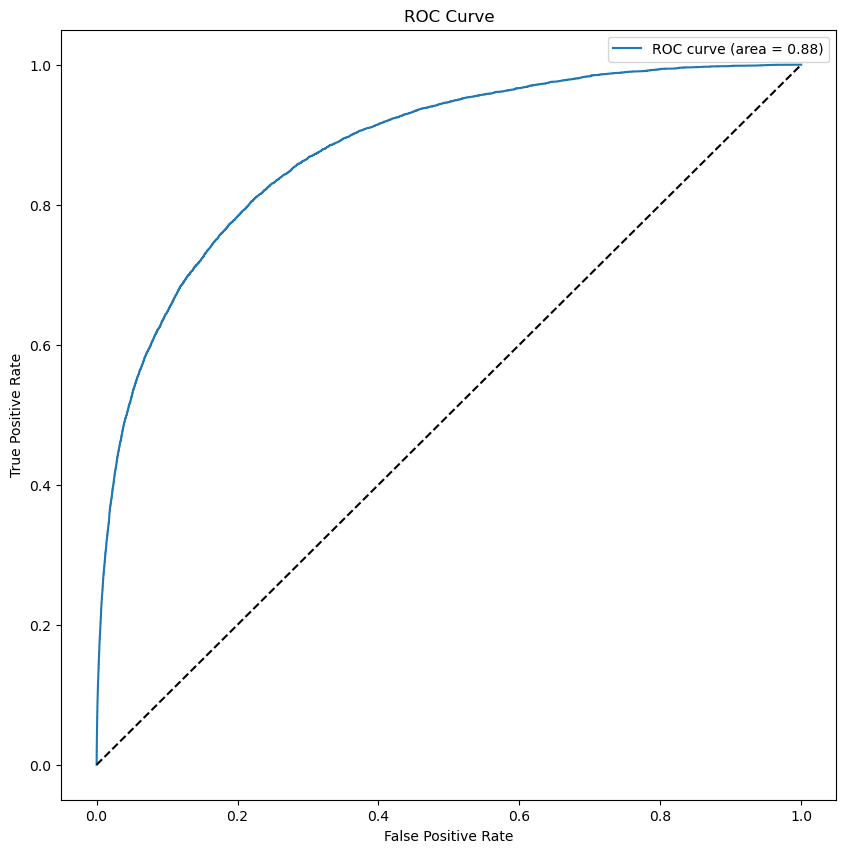

In [57]:
evaluate_model(mod_1, X_oot, y_oot)

In [58]:
# print feature importance
feature_importances = pd.Series(mod_1.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)
print(feature_importances)

max_air_temperature                          0.213407
road_density_km_km2                          0.074000
precipitation_amount                         0.051178
veg_Native Grassland                         0.037703
veg_Agriculture                              0.037276
veg_Native Inland Scrub                      0.036726
min_air_temperature                          0.035656
SWE                                          0.028234
slope_avg                                    0.027805
veg_Native Conifer Alpine                    0.027095
slope_max                                    0.026654
dead_fuel_moisture_1000hr                    0.026379
veg_Non-native grassland                     0.025911
veg_Riparian                                 0.024878
surface_downwelling_shortwave_flux_in_air    0.021820
veg_Native Coastal Sage Scrub                0.020543
veg_Native Conifer Forest                    0.020499
veg_Non-native shrub                         0.019810
veg_Native Desert           

In [62]:
Eval_data.columns

Index(['day', 'dead_fuel_moisture_1000hr', 'dead_fuel_moisture_100hr', 'pdsi',
       'pdsi_class', 'max_air_temperature', 'max_relative_humidity',
       'max_wind_speed', 'min_air_temperature', 'min_relative_humidity',
       'precipitation_amount', 'specific_humidity',
       'surface_downwelling_shortwave_flux_in_air', 'wind_from_direction',
       'wind_speed', 'SWE', 'IS_FIRE', 'NWCG_CAUSE_CLASSIFICATION',
       'min_FIRE_SIZE', 'max_FIRE_SIZE', 'veg_type_details', 'fire_attribute',
       'slope_avg', 'slope_max', 'road_density_km_km2',
       'wind_direction_category_N', 'wind_direction_category_NE',
       'wind_direction_category_E', 'wind_direction_category_SE',
       'wind_direction_category_S', 'wind_direction_category_SW',
       'wind_direction_category_W', 'wind_direction_category_NW',
       'veg_Agriculture ', 'veg_Barren ', 'veg_Native Chapparal ',
       'veg_Native Coastal Sage Scrub ', 'veg_Native Conifer Alpine ',
       'veg_Native Conifer Forest ', 'veg_Nativ

### Performance on Big fire vs Small Fire

In [70]:
Eval_data['IS_FIRE'].value_counts()

IS_FIRE
0    6284671
1       8630
Name: count, dtype: int64

In [71]:
# when IS_FIRE = 1, check percentile of min_FIRE_SIZE
Eval_data[Eval_data['IS_FIRE'] == 1]['min_FIRE_SIZE'].quantile([0.1,0.25,0.5,0.75,0.82,0.9])

0.10    0.01
0.25    0.10
0.50    0.20
0.75    1.00
0.82    1.00
0.90    3.00
Name: min_FIRE_SIZE, dtype: float64

In [75]:
# Eval_Big_Fire = Eval_data[Eval_data['max_FIRE_SIZE'] > 1] or IS_FIRE = 0
Eval_Big_Fire = Eval_data[(Eval_data['max_FIRE_SIZE'] > 1) | (Eval_data['IS_FIRE'] == 0)]

In [76]:
Eval_Big_Fire['IS_FIRE'].value_counts()

IS_FIRE
0    6284671
1       1569
Name: count, dtype: int64

In [77]:
X_oot = Eval_Big_Fire.drop(columns=not_in_features)
y_oot = Eval_Big_Fire['IS_FIRE']

ROC AUC on evaluation data: 0.8708267533441434


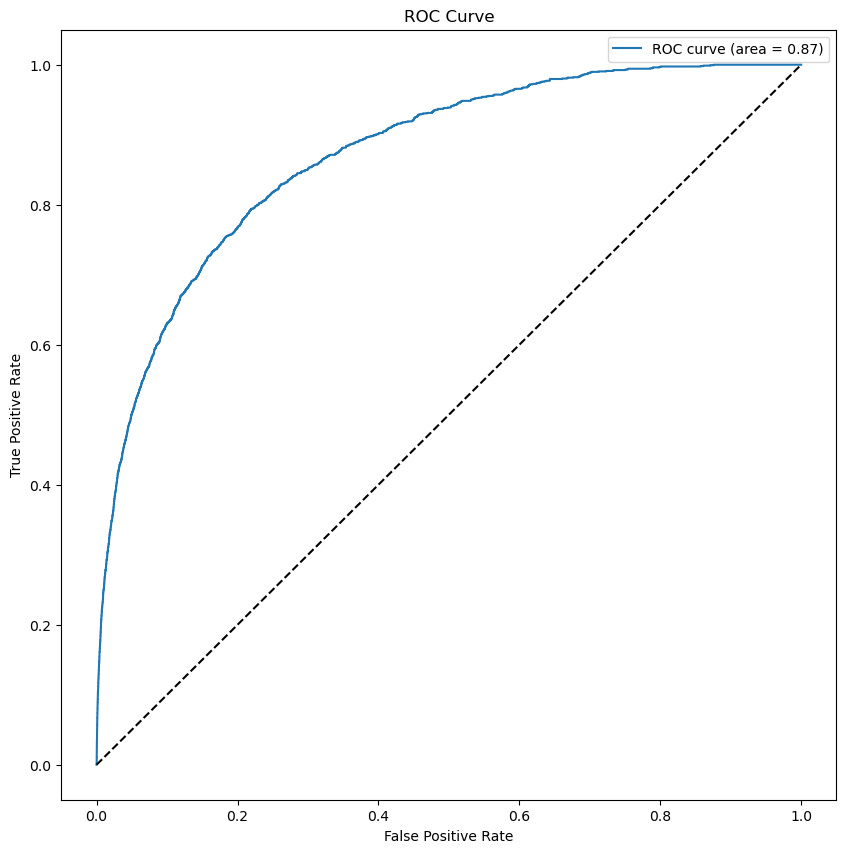

In [78]:
evaluate_model(mod_1, X_oot, y_oot)

### Performance on Human vs Natural

In [86]:
# astype Eval_data['NWCG_CAUSE_CLASSIFICATION'] to string
Eval_data['NWCG_CAUSE_CLASSIFICATION'] = Eval_data['NWCG_CAUSE_CLASSIFICATION'].astype(str)

In [87]:
Eval_data['NWCG_CAUSE_CLASSIFICATION'].value_counts()

NWCG_CAUSE_CLASSIFICATION
None                                                    6284671
'Human'                                                    4113
'Missing data/not specified/undetermined'                  3869
'Natural'                                                   551
'Human', 'Missing data/not specified/undetermined'           93
'Missing data/not specified/undetermined', 'Natural'          3
'Human', 'Natural'                                            1
Name: count, dtype: int64

In [88]:
# filter rows that have NWCG_CAUSE_CLASSIFICATION CONTAINS 'Human' or IS_FIRE = 0
Eval_Human = Eval_data[(Eval_data['NWCG_CAUSE_CLASSIFICATION'].str.contains('Human')) | (Eval_data['IS_FIRE'] == 0)]
X_oot = Eval_Human.drop(columns=not_in_features)
y_oot = Eval_Human['IS_FIRE']

In [89]:
Eval_Human['IS_FIRE'].value_counts()

IS_FIRE
0    6284671
1       4207
Name: count, dtype: int64

ROC AUC on evaluation data: 0.86549908930757


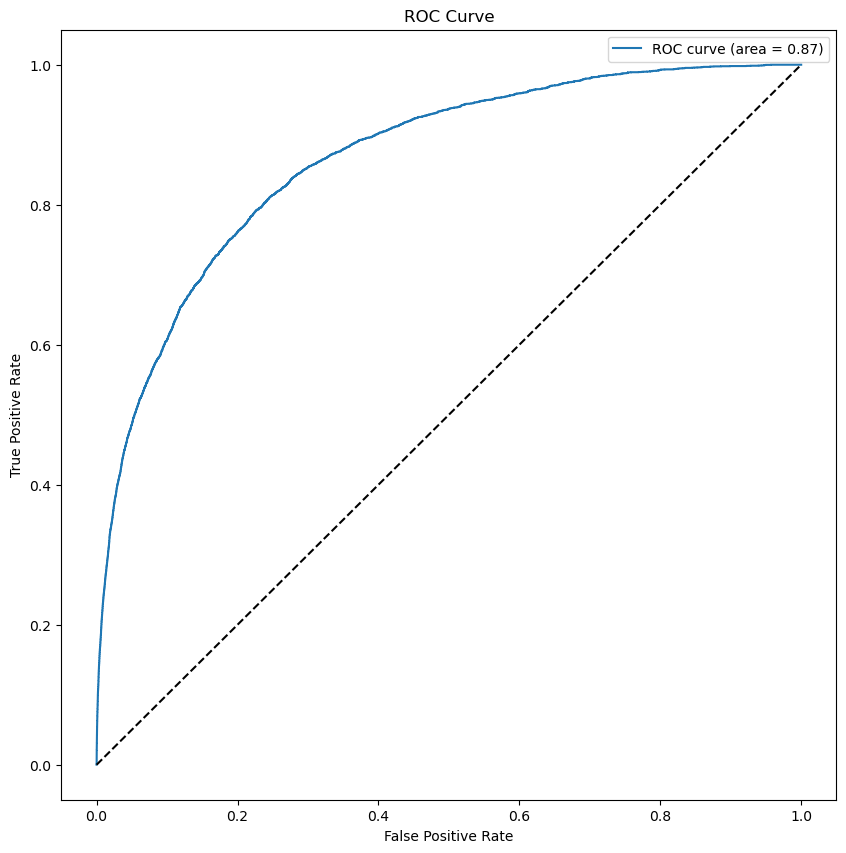

In [90]:
evaluate_model(mod_1, X_oot, y_oot)

--- old code below (not updated since Feb 7th)

2. Train the best model using parameter tuning

In [30]:
# Define parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Generate all combinations of parameters
param_combinations = list(itertools.product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['learning_rate'],
    param_grid['subsample']
))

best_auc = 0
best_params = None

warnings.filterwarnings('ignore')
for params in param_combinations:
    n_estimators, max_depth, learning_rate, subsample = params
    model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    model.fit(X_train, y_train)
    y_val_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)
    print(f'Params: {params}, AUC: {auc}')
    if auc > best_auc:
        best_auc = auc
        best_params = params

print(f'Best Params: {best_params}, Best AUC: {best_auc}')

Params: (50, 3, 0.01, 0.8), AUC: 0.7012661320613301
Params: (50, 3, 0.01, 1.0), AUC: 0.6988372444845999
Params: (50, 3, 0.1, 0.8), AUC: 0.7342715148973389
Params: (50, 3, 0.1, 1.0), AUC: 0.7335862006686212
Params: (50, 3, 0.2, 0.8), AUC: 0.7487046412800992
Params: (50, 3, 0.2, 1.0), AUC: 0.7480784710757603
Params: (50, 4, 0.01, 0.8), AUC: 0.718798850494931
Params: (50, 4, 0.01, 1.0), AUC: 0.717000550210361
Params: (50, 4, 0.1, 0.8), AUC: 0.7424443723421668
Params: (50, 4, 0.1, 1.0), AUC: 0.7422349876290628
Params: (50, 4, 0.2, 0.8), AUC: 0.7575024547416342
Params: (50, 4, 0.2, 1.0), AUC: 0.7568895987604864
Params: (50, 5, 0.01, 0.8), AUC: 0.7270423036665794
Params: (50, 5, 0.01, 1.0), AUC: 0.7211029043107591
Params: (50, 5, 0.1, 0.8), AUC: 0.7499570497892306
Params: (50, 5, 0.1, 1.0), AUC: 0.7490969234313384
Params: (50, 5, 0.2, 0.8), AUC: 0.7657625846034829
Params: (50, 5, 0.2, 1.0), AUC: 0.7654115024098513
Params: (100, 3, 0.01, 0.8), AUC: 0.7077144365775018
Params: (100, 3, 0.01, 1.

In [31]:
# Train the best model on the full training data
best_model = xgb.XGBClassifier(
    n_estimators=best_params[0],
    max_depth=best_params[1],
    learning_rate=best_params[2],
    subsample=best_params[3],
    use_label_encoder=False,
    eval_metric='logloss'
)
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [32]:
# save the best model
best_model.save_model('../Model/xgb_model_02042025.json')

In [33]:
# read the best model
best_model = xgb.XGBClassifier()
best_model.load_model('../Model/xgb_model_02042025.json')

ROC AUC on evaluation data: 0.707280878625083


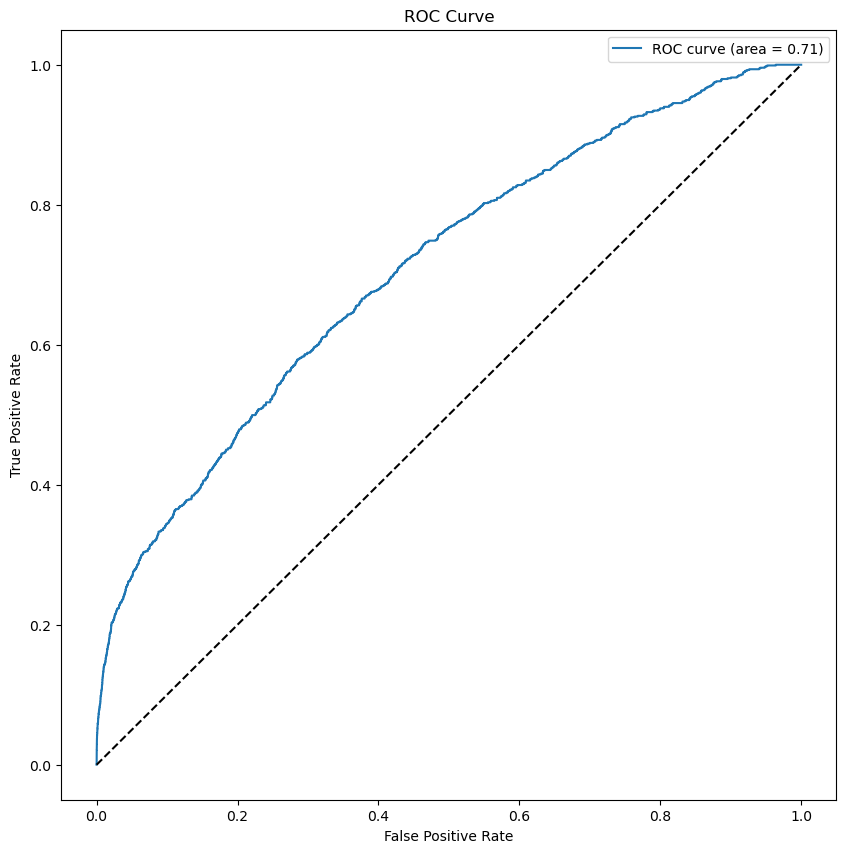

In [34]:
evaluate_model(best_model, X_oot_downsampled, y_oot_downsampled)

ROC AUC on evaluation data: 0.7260742678040557


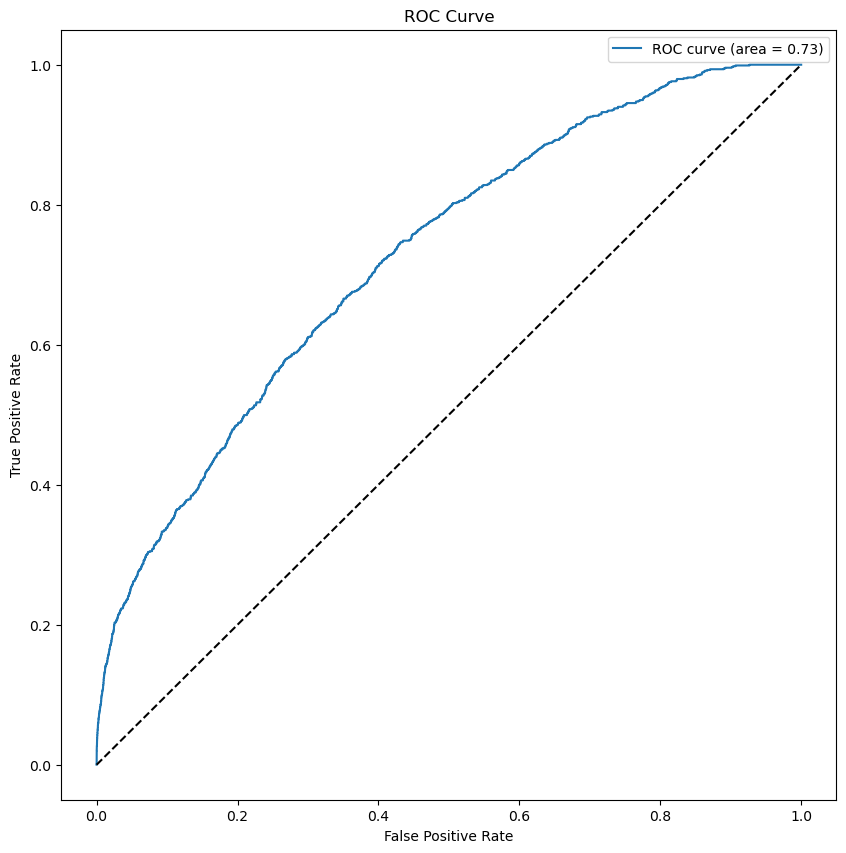

In [35]:
evaluate_model(best_model, X_oot, y_oot)

In [36]:
# print feature importance
feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)
print(feature_importances)

road_density_km_km2                          0.122923
precipitation_amount                         0.085398
max_air_temperature                          0.072797
fire_attribute_ low                          0.070704
slope_max                                    0.063213
fire_attribute_ fire                         0.056314
min_relative_humidity                        0.054245
fire_attribute_ archetypical                 0.050818
slope_avg                                    0.045047
fire_attribute_ never                        0.043882
fire_attribute_ rarely                       0.042164
dead_fuel_moisture_1000hr                    0.035898
max_relative_humidity                        0.034245
min_air_temperature                          0.033933
surface_downwelling_shortwave_flux_in_air    0.030947
fire_attribute_ mesic                        0.030089
dead_fuel_moisture_100hr                     0.028484
specific_humidity                            0.023247
pdsi                        

old result below before adding slope. no need anymore

c:\Users\fangshuye\AppData\Local\anaconda3\envs\py311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:07:24] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


ROC AUC on OOT data: 0.8003905590653241


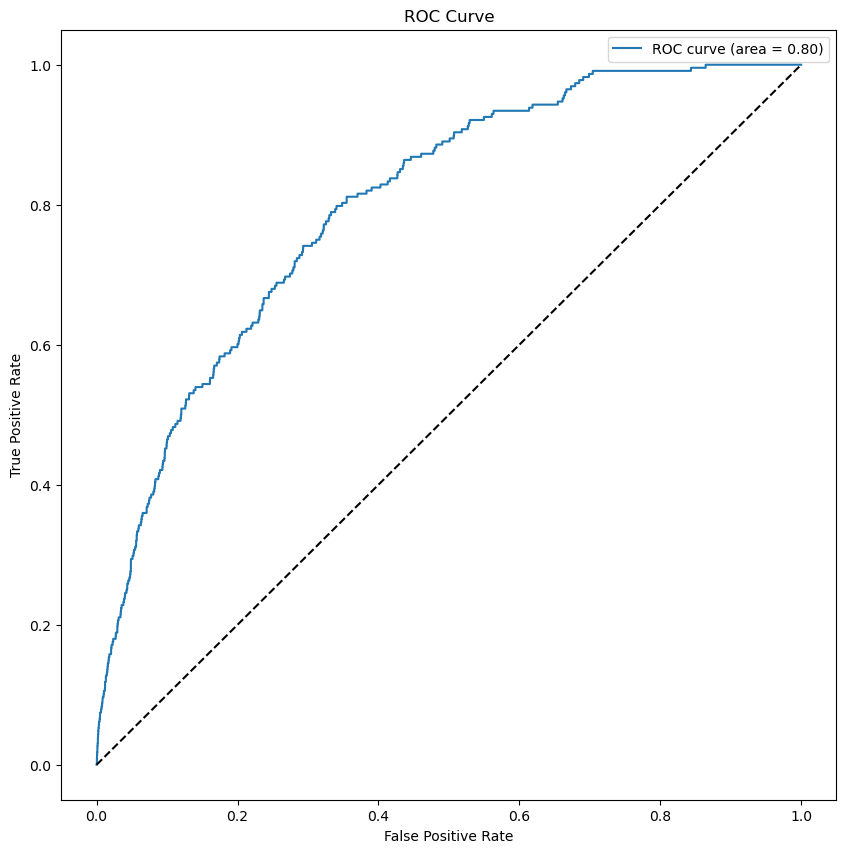

In [70]:
# Train the best model on the full training data
best_model = xgb.XGBClassifier(
    n_estimators=best_params[0],
    max_depth=best_params[1],
    learning_rate=best_params[2],
    subsample=best_params[3],
    use_label_encoder=False,
    eval_metric='logloss'
)
best_model.fit(X_train, y_train)

ROC AUC on OOT data: 0.7693476377420636


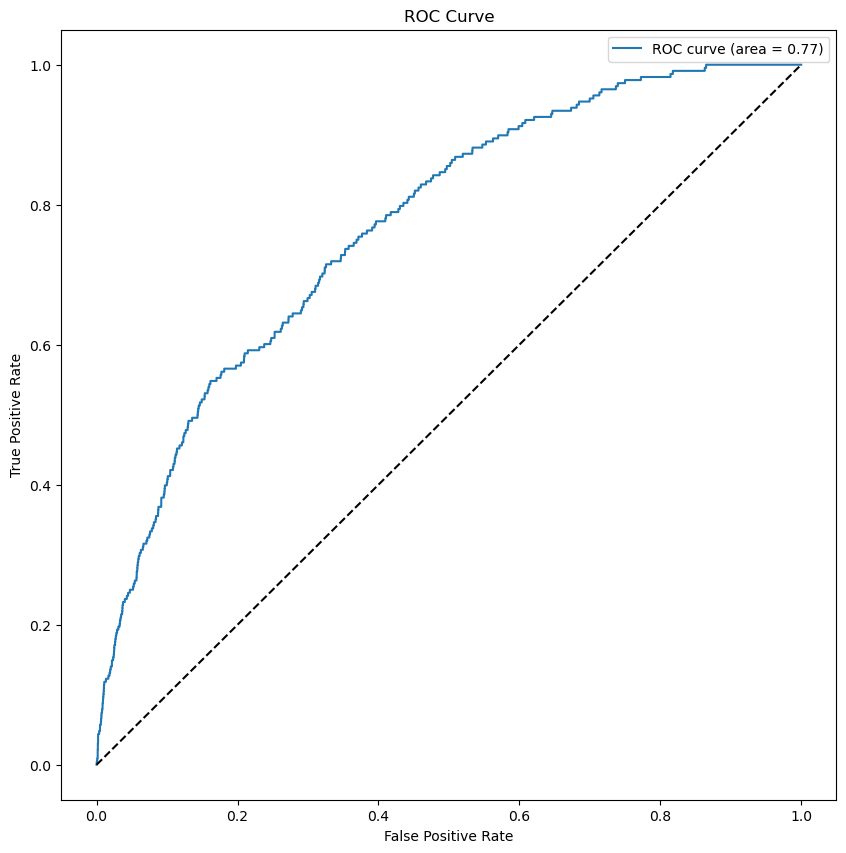

In [66]:
# no parameter tuning

# Predict on OOT data
y_oot_pred = model.predict_proba(X_oot)[:, 1]

# Calculate ROC AUC on OOT data
roc_auc = roc_auc_score(y_oot, y_oot_pred)
print(f'ROC AUC on OOT data: {roc_auc}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_oot, y_oot_pred)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

ROC AUC on OOT data: 0.7429704195341196


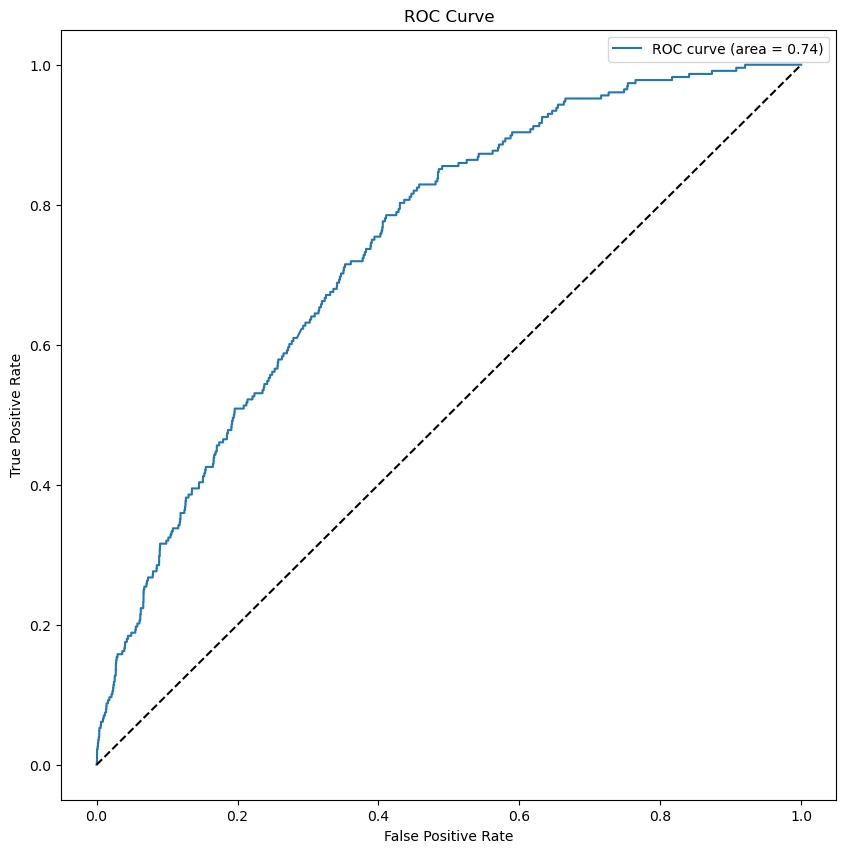

In [ ]:
# no parameter tuning, no veg type in features

# Predict on OOT data
y_oot_pred = model.predict_proba(X_oot)[:, 1]

# Calculate ROC AUC on OOT data
roc_auc = roc_auc_score(y_oot, y_oot_pred)
print(f'ROC AUC on OOT data: {roc_auc}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_oot, y_oot_pred)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()